# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

2022-01-13 11:07:22.578378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-13 11:07:22.578423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data

df.drop(df[df.DKAPast12mos == 2].index, inplace=True)


In [5]:
df1 = df.loc[(df['DKAPast12mos'] ==0 ) & (df['Pt_HospDKASinceDiag'] == 0)]
len(df1)

166

### for DKA events prediction pre processing


In [6]:
y_label = 'DKAPast12mos' 

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['DKAPast12mos'])):
        if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# DKADiag {'1.Yes': 0, '2.Probably Yes': 1, '3.No': 2, '4.Unknown': 3}
df['DKADiag'] = df['DKADiag'].replace({1.0: 0.0, 2.0:1.0, 3.0:1.0})
    
get_possible_vals_with_nan(df, 'DKADiag')


[1.0, 0.0]

In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'ReqInsulinCrit', 'DKADiag', 'OralAgnTrt', 'ExamDaysFromConsent', 'Gender', 'Weight', 'Height', 'BldPrSys', 'BldPrDia', 'InsulinDeliv', 'Lypohyper', 'Lipoatrophy', 'AcanNigrDiag', 'PulseRate', 'AcanNigrP

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsHumalog,Pt_InsNovolog,Pt_InsApidra,Pt_InsRegular,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,19861.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


# Divide Dataset

In [11]:
df=df.drop('PtID', axis = 1)

In [12]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [13]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsHumalog,Pt_InsNovolog,Pt_InsApidra,Pt_InsRegular,Pt_InsNPH,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,0.0,0.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,3.0,1.0,2.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,0.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


In [14]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [15]:
Y.unique()

array([1., 0.])

# Feature Selection

In [16]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [17]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [18]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 150 4478]
Test -  [0. 1.] [  50 1493]


# Imputations

<AxesSubplot:>

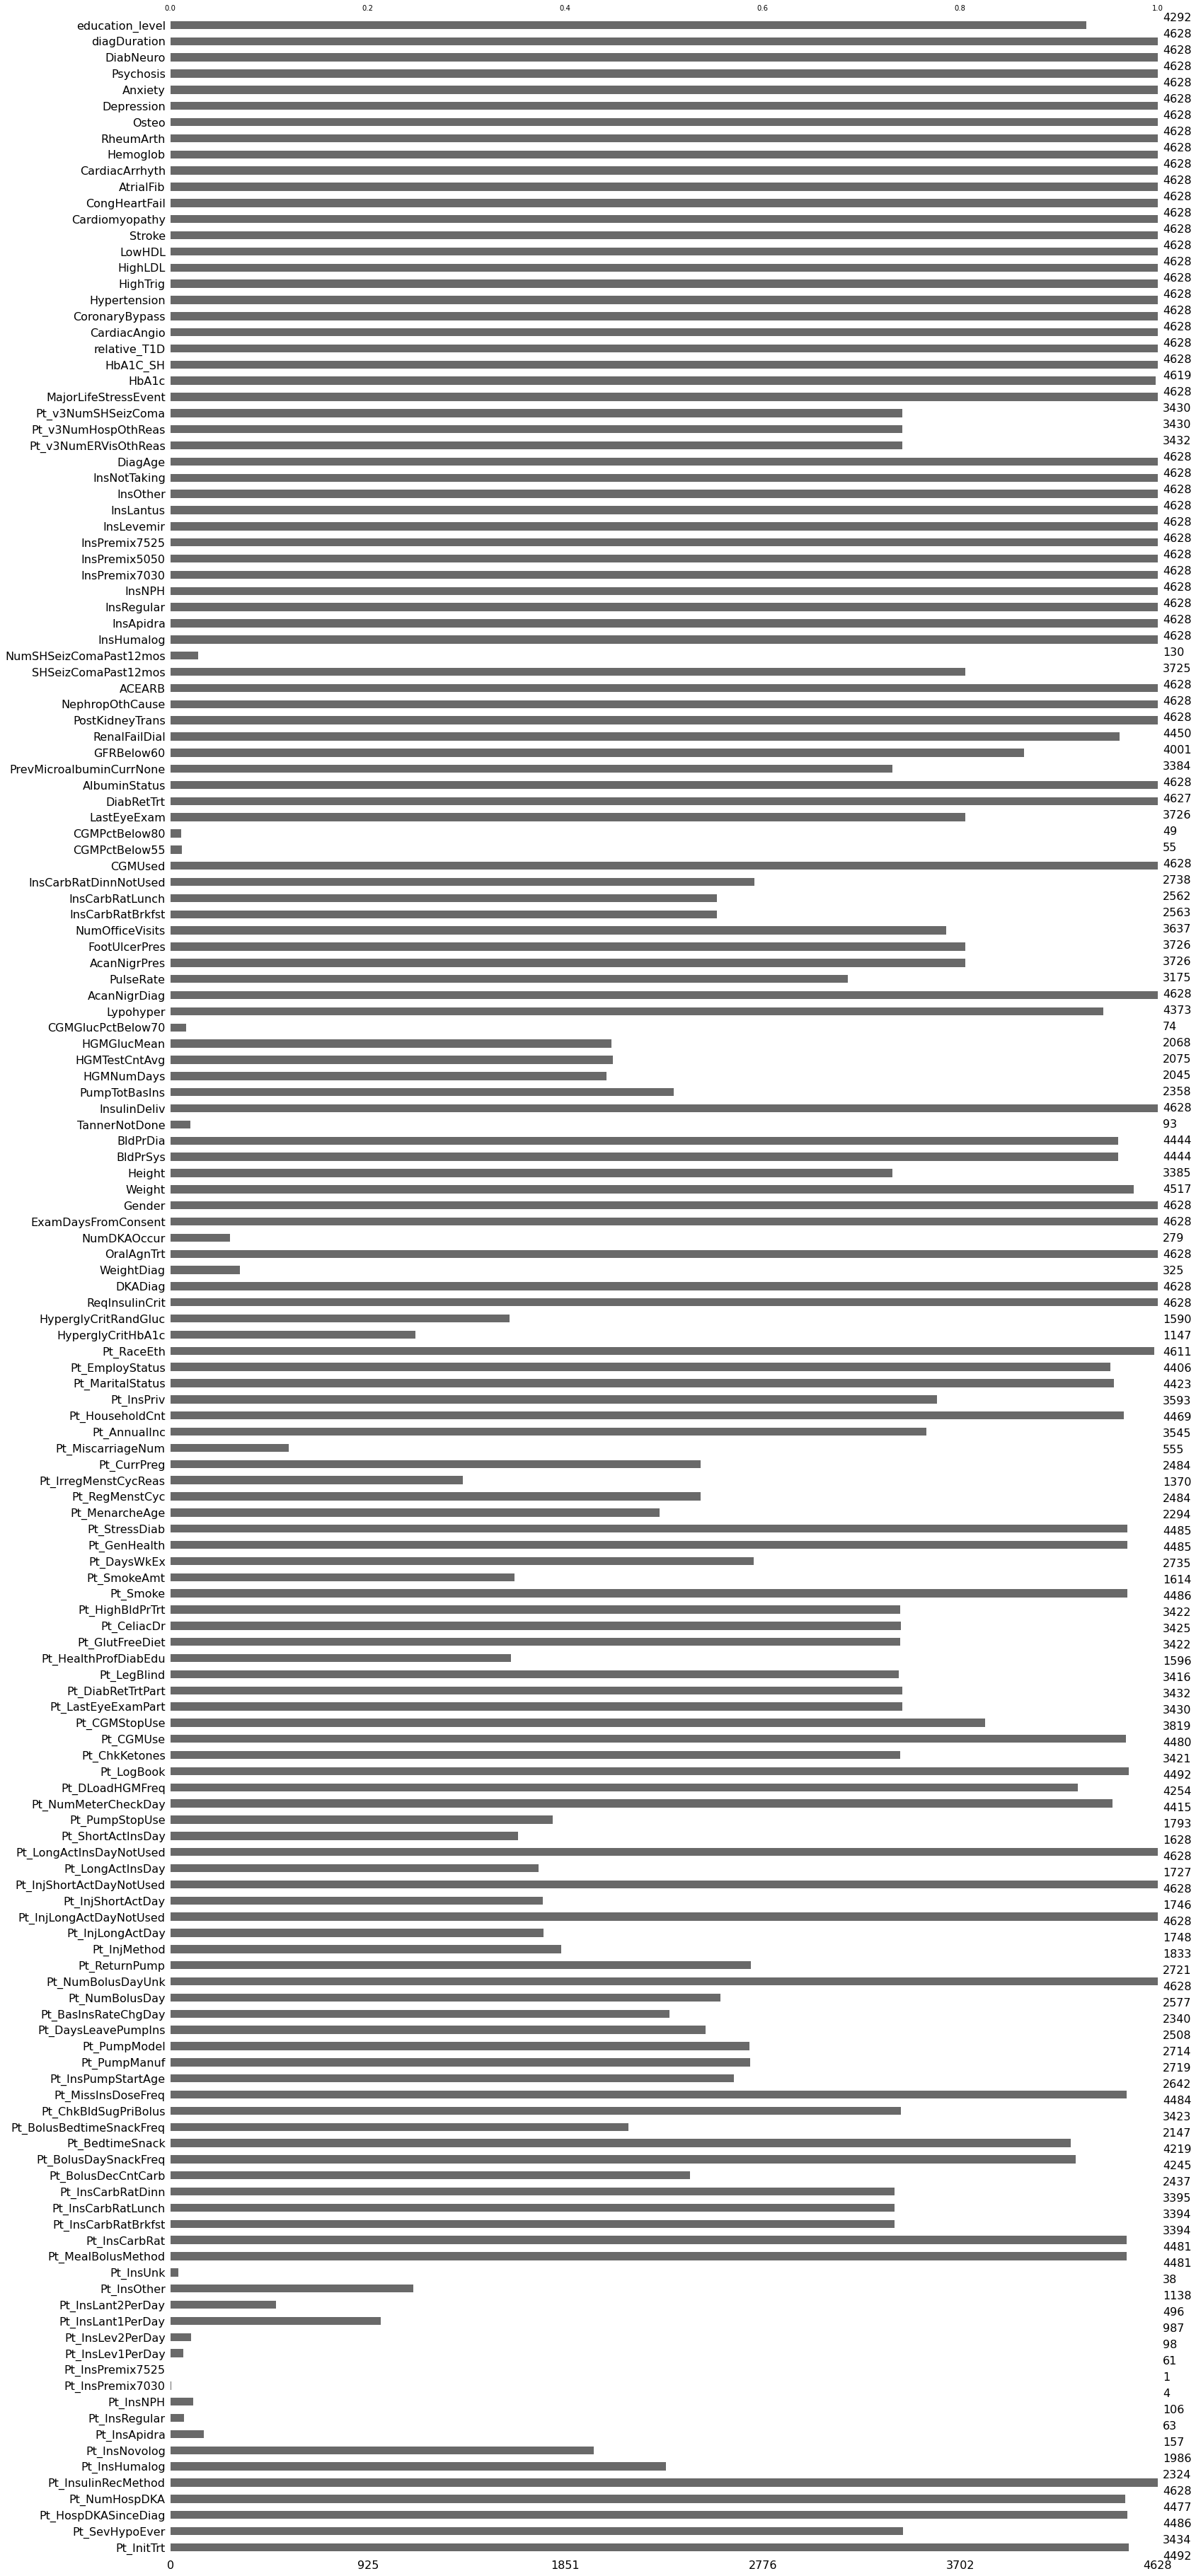

In [19]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [20]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [21]:
# use only for XGB classifier with missing values
X_train_copy = X_train.drop(['NumDKAOccur', 'Pt_NumHospDKA'], axis=1)
X_test_copy = X_test.drop(['NumDKAOccur', 'Pt_NumHospDKA'], axis=1)

# features_set = ['Pt_InsCarbRat',
#        'Pt_MissInsDoseFreq', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay',
#        'Pt_NumMeterCheckDay', 'Pt_ChkKetones', 'Pt_LastEyeExamPart',
#        'Pt_SmokeAmt', 'Pt_GenHealth', 'Pt_EmployStatus',
#        'ExamDaysFromConsent', 'Height', 'PumpTotBasIns', 'PulseRate',
#        'InsCarbRatDinnNotUsed', 'LastEyeExam', 'DiagAge',
#        'Pt_v3NumERVisOthReas', 'Pt_v3NumSHSeizComa', 'HbA1c', 'Psychosis',
#        'diagDuration']

# X_train_copy = X_train_copy[features_set]
# X_test_copy = X_test_copy[features_set]

In [22]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values

def cross_val_with_missing_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



Accuracy for the fold no. 1 on the test set: 0.9650032404407, doublecheck: 0.9650032404407
Accuracy for the fold no. 2 on the test set: 0.9669475048606611, doublecheck: 0.9669475048606611
Accuracy for the fold no. 3 on the test set: 0.9662775616083009, doublecheck: 0.9662775616083009

 
 ===========   Train Dataset    =============
train ROC score 0.9357972309066548
Threshold value is: 2.1670218


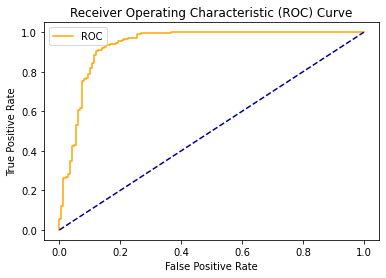

accuracy score:  90.5790838375108
              precision    recall  f1-score   support

         0.0       0.24      0.88      0.38       150
         1.0       1.00      0.91      0.95      4478

    accuracy                           0.91      4628
   macro avg       0.62      0.89      0.66      4628
weighted avg       0.97      0.91      0.93      4628



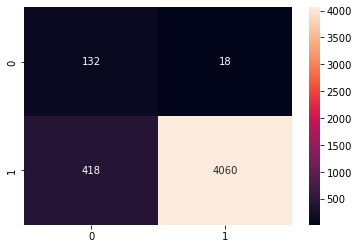

Accuracy of XGB on training set: 0.99


 ===========   Test Dataset    =============
Threshold value is: 2.5290766


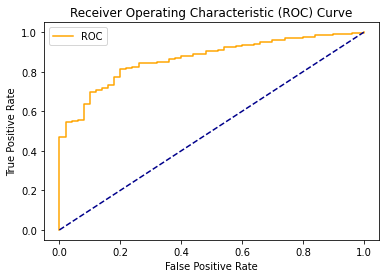

accuracy score:  81.3350615683733
              precision    recall  f1-score   support

         0.0       0.13      0.80      0.22        50
         1.0       0.99      0.81      0.89      1493

    accuracy                           0.81      1543
   macro avg       0.56      0.81      0.56      1543
weighted avg       0.96      0.81      0.87      1543



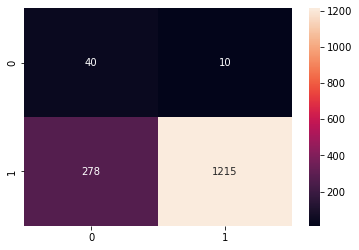

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8661


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.8        0.81379772]
average accuracy:  0.8068988613529806


In [23]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
#         max_delta_step = 10,
# # #         scale_pos_weight = 0.4,
# # #         n_jobs = 0,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
# #         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)




<AxesSubplot:>

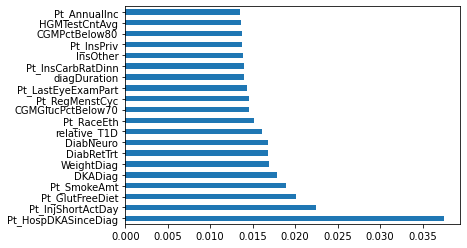

In [24]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:162])
feat_importances.nlargest(20).plot(kind='barh')

### LGBM Classifier with missing values

Accuracy for the fold no. 1 on the test set: 0.9669475048606611, doublecheck: 0.9669475048606611
Accuracy for the fold no. 2 on the test set: 0.966299416720674, doublecheck: 0.966299416720674
Accuracy for the fold no. 3 on the test set: 0.9662775616083009, doublecheck: 0.9662775616083009

 
 ===========   Train Dataset    =============
train ROC score 0.9334122376060743
Threshold value is: 0.9741847665089335


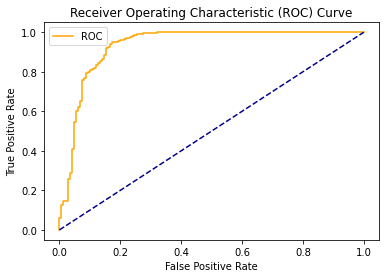

accuracy score:  94.57649092480554
              precision    recall  f1-score   support

         0.0       0.36      0.83      0.50       150
         1.0       0.99      0.95      0.97      4478

    accuracy                           0.95      4628
   macro avg       0.67      0.89      0.73      4628
weighted avg       0.97      0.95      0.96      4628



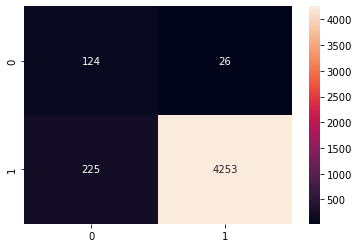

Accuracy of XGB on training set: 0.99


 ===========   Test Dataset    =============
Threshold value is: 0.9968226862477387


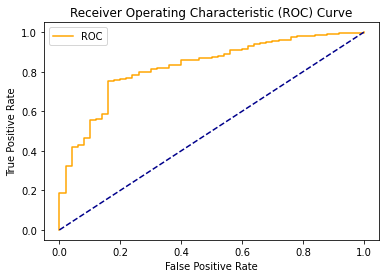

accuracy score:  75.69669475048607
              precision    recall  f1-score   support

         0.0       0.10      0.84      0.18        50
         1.0       0.99      0.75      0.86      1493

    accuracy                           0.76      1543
   macro avg       0.55      0.80      0.52      1543
weighted avg       0.96      0.76      0.84      1543



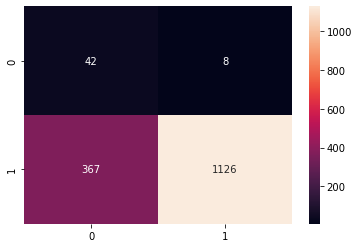

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8255


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.84      0.7541862]
average accuracy:  0.7970931011386471
f1 0.8572516178149981


In [25]:

import lightgbm as ltb

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.1, 
                         max_depth =5, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

In [26]:
X_train.update(X_train[[
             'Pt_InsPriv', 'Pt_InsHumalog', 'Pt_InsNovolog','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone','Pt_InsApidra',
             'Pt_InsRegular','Pt_InsNPH','Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsOther',]].fillna(0))

X_test.update(X_test[[
             'Pt_InsPriv', 'Pt_InsHumalog', 'Pt_InsNovolog','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone','Pt_InsApidra',
             'Pt_InsRegular','Pt_InsNPH','Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsOther',]].fillna(0))

/usr/lib/python3/dist-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [27]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [28]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [29]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [30]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [31]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [32]:
# Feature selection
selected, fs, idx = select_features(select, feature)


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [33]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsCarbRat',
       'Pt_MissInsDoseFreq', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay',
       'Pt_NumMeterCheckDay', 'Pt_ChkKetones', 'Pt_LastEyeExamPart',
       'Pt_SmokeAmt', 'Pt_GenHealth', 'Pt_EmployStatus', 'NumDKAOccur',
       'ExamDaysFromConsent', 'Height', 'PumpTotBasIns', 'PulseRate',
       'InsCarbRatDinnNotUsed', 'LastEyeExam', 'DiagAge',
       'Pt_v3NumERVisOthReas', 'Pt_v3NumSHSeizComa', 'HbA1c', 'Psychosis',
       'diagDuration'],
      dtype='object')
(6171, 25)


In [34]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [35]:

if('NumDKAOccur' in X_train.columns):
    X_train = X_train.drop(['NumDKAOccur'], axis=1)
    X_test = X_test.drop([ 'NumDKAOccur'], axis=1)
if('Pt_NumHospDKA' in X_train.columns):
    X_train = X_train.drop(['Pt_NumHospDKA'], axis=1)
    X_test = X_test.drop([ 'Pt_NumHospDKA'], axis=1)
# if('Pt_HospDKASinceDiag' in X_train.columns):
#     X_train = X_train.drop(['Pt_HospDKASinceDiag'], axis=1)
#     X_test = X_test.drop([ 'Pt_HospDKASinceDiag'], axis=1)


### Common functions

In [36]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_ test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [37]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    return optimal_threshold

In [38]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.966299416720674, doublecheck: 0.966299416720674
Accuracy for the fold no. 2 on the test set: 0.966299416720674, doublecheck: 0.966299416720674
Accuracy for the fold no. 3 on the test set: 0.9669260700389105, doublecheck: 0.9669260700389105
0.8302746148693905
Threshold value is: 0.5202601110624251


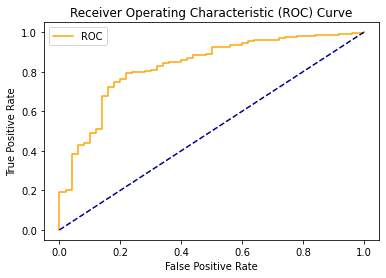

0.8863666815542653
Threshold value is: 0.5213141972548159


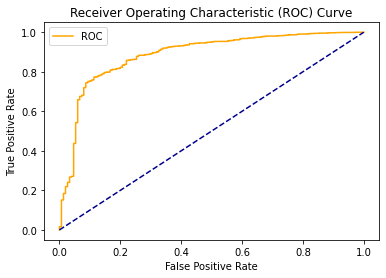


 
 =====================   Train Dataset    ======================
77.67934312878133
              precision    recall  f1-score   support

         0.0       0.12      0.89      0.20       150
         1.0       1.00      0.77      0.87      4478

    accuracy                           0.78      4628
   macro avg       0.56      0.83      0.54      4628
weighted avg       0.97      0.78      0.85      4628



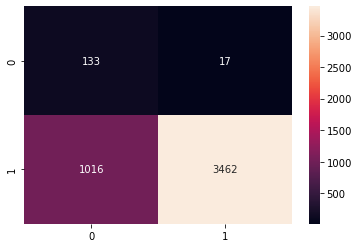

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
79.13156189241737
              precision    recall  f1-score   support

         0.0       0.11      0.78      0.20        50
         1.0       0.99      0.79      0.88      1493

    accuracy                           0.79      1543
   macro avg       0.55      0.79      0.54      1543
weighted avg       0.96      0.79      0.86      1543



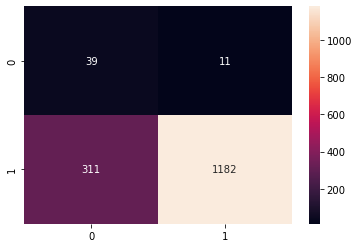

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.8303


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.78       0.79169457]
average accuracy:  0.7858472873409243


In [39]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.05, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

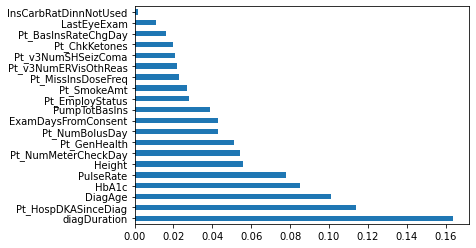

In [40]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.9688917692806222, doublecheck: 0.9688917692806222
Accuracy for the fold no. 2 on the test set: 0.9682436811406351, doublecheck: 0.9682436811406351
Accuracy for the fold no. 3 on the test set: 0.9662775616083009, doublecheck: 0.9662775616083009
0.8179236436704622
Threshold value is: 2.5877872


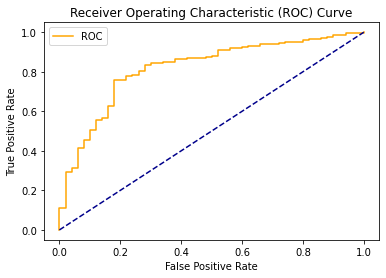

0.9284189370254579
Threshold value is: 1.9384077


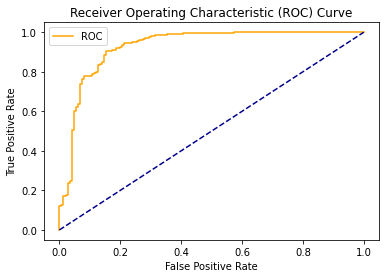


 
 =====================   Train Dataset    ======================
90.27657735522904
              precision    recall  f1-score   support

         0.0       0.23      0.85      0.36       150
         1.0       0.99      0.90      0.95      4478

    accuracy                           0.90      4628
   macro avg       0.61      0.88      0.65      4628
weighted avg       0.97      0.90      0.93      4628



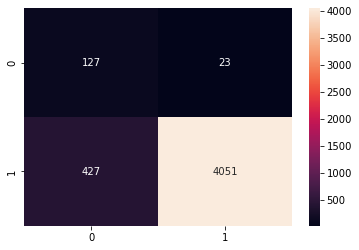

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
75.82631237848348
              precision    recall  f1-score   support

         0.0       0.10      0.82      0.18        50
         1.0       0.99      0.76      0.86      1493

    accuracy                           0.76      1543
   macro avg       0.55      0.79      0.52      1543
weighted avg       0.96      0.76      0.84      1543



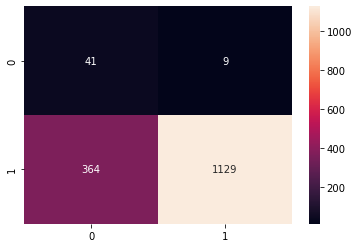

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.8179


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.82       0.75619558]
average accuracy:  0.7880977896851975


In [41]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

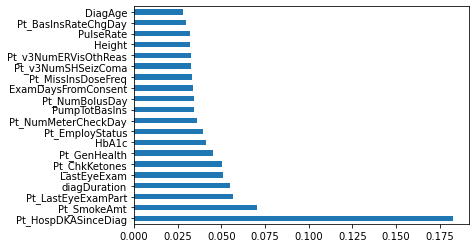

In [42]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.7932598833441348, doublecheck: 0.7932598833441348
Accuracy for the fold no. 2 on the test set: 0.778353856124433, doublecheck: 0.778353856124433
Accuracy for the fold no. 3 on the test set: 0.814526588845655, doublecheck: 0.814526588845655
0.8549899531145345
Threshold value is: 0.5519931330565615


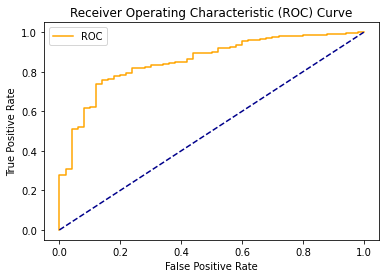

0.8880020842638081
Threshold value is: 0.5128553706387992


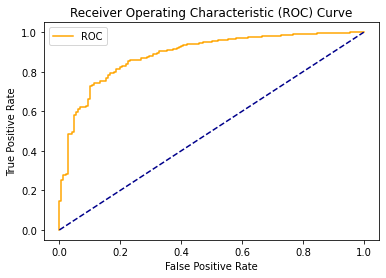


 
 =====================   Train Dataset    ======================
79.58081244598098
              precision    recall  f1-score   support

         0.0       0.12      0.83      0.21       150
         1.0       0.99      0.79      0.88      4478

    accuracy                           0.80      4628
   macro avg       0.56      0.81      0.55      4628
weighted avg       0.96      0.80      0.86      4628



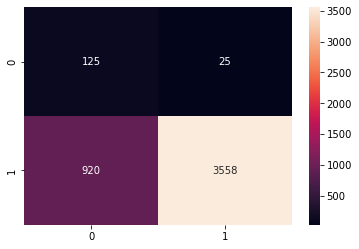

Accuracy of on training set: 0.81


 =====================   Test Dataset    =======================
76.34478289047311
              precision    recall  f1-score   support

         0.0       0.11      0.86      0.19        50
         1.0       0.99      0.76      0.86      1493

    accuracy                           0.76      1543
   macro avg       0.55      0.81      0.53      1543
weighted avg       0.97      0.76      0.84      1543



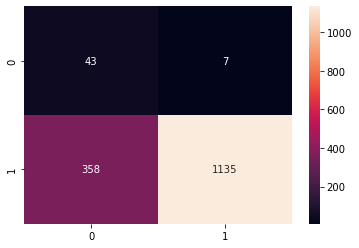

Accuracy of classifier on test set: 0.80


 =======================   Test-ROC    =========================
roc_auc = 0.855


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.86       0.76021433]
average accuracy:  0.8101071667782987


In [63]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=5,
#                              n_estimators = feature,
                             criterion = 'gini', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
optimal_threshold = optimal_thresh(rf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

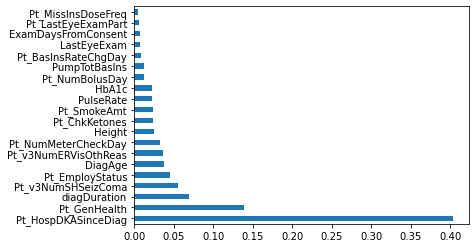

In [64]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Accuracy for the fold no. 1 on the test set: 0.7336357744653272, doublecheck: 0.7336357744653272
Accuracy for the fold no. 2 on the test set: 0.76150356448477, doublecheck: 0.76150356448477


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy for the fold no. 3 on the test set: 0.7937743190661478, doublecheck: 0.7937743190661478
0.7853181513730744
Threshold value is: 0.5399438393680368


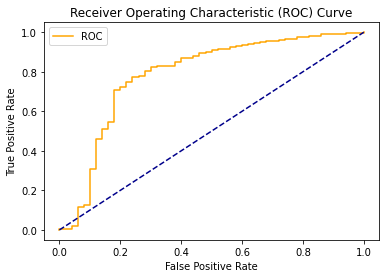

0.8404079202024713
Threshold value is: 0.5939895527611861


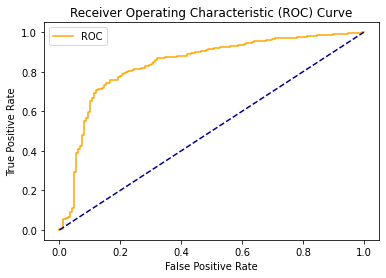


 
 =====================   Train Dataset    ======================
74.71910112359551
              precision    recall  f1-score   support

         0.0       0.10      0.85      0.18       150
         1.0       0.99      0.74      0.85      4478

    accuracy                           0.75      4628
   macro avg       0.55      0.80      0.51      4628
weighted avg       0.96      0.75      0.83      4628



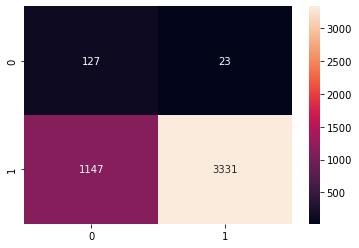

Accuracy of on training set: 0.79


 =====================   Test Dataset    =======================
77.25210628645496
              precision    recall  f1-score   support

         0.0       0.10      0.76      0.18        50
         1.0       0.99      0.77      0.87      1493

    accuracy                           0.77      1543
   macro avg       0.55      0.77      0.52      1543
weighted avg       0.96      0.77      0.85      1543



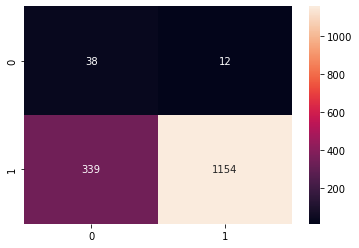

Accuracy of classifier on test set: 0.79


 =======================   Test-ROC    =========================
roc_auc = 0.7853


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.76       0.77294039]
average accuracy:  0.7664701942397857


In [45]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

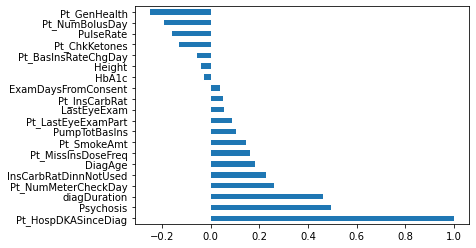

In [46]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

Accuracy for the fold no. 1 on the test set: 0.9358392741412832, doublecheck: 0.9358392741412832
Accuracy for the fold no. 2 on the test set: 0.9384316267012314, doublecheck: 0.9384316267012314
Accuracy for the fold no. 3 on the test set: 0.9487678339818417, doublecheck: 0.9487678339818417
0.5429202947086403
Threshold value is: 1.0


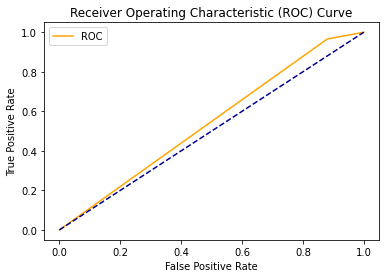

0.8558686913800804
Threshold value is: 1.0


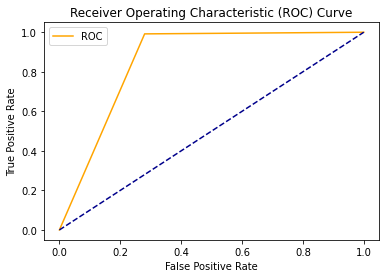


 
 =====================   Train Dataset    ======================
98.29299913569577
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       150
         1.0       0.99      0.99      0.99      4478

    accuracy                           0.98      4628
   macro avg       0.87      0.86      0.86      4628
weighted avg       0.98      0.98      0.98      4628



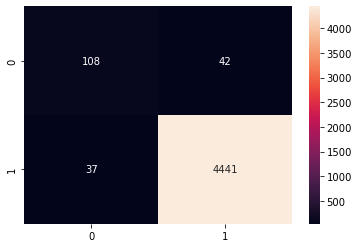

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
93.84316267012314
              precision    recall  f1-score   support

         0.0       0.11      0.12      0.11        50
         1.0       0.97      0.97      0.97      1493

    accuracy                           0.94      1543
   macro avg       0.54      0.54      0.54      1543
weighted avg       0.94      0.94      0.94      1543



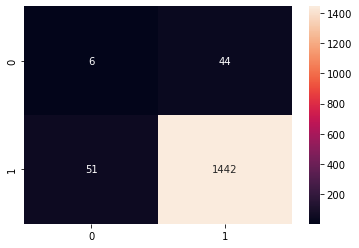

Accuracy of classifier on test set: 0.94


 =======================   Test-ROC    =========================
roc_auc = 0.5429


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.12       0.96584059]
average accuracy:  0.5429202947086403


In [47]:
clf = DecisionTreeClassifier(
                        random_state=0,
                        criterion='gini',
                        splitter = 'best',
                        max_depth = 100,
                        max_features = 18)
# clf.fit(X_train, Y_train)
clf = cross_val(clf)

# pred=clf.predict(X_test)
# pred_train=clf.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(clf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(clf, X_train, Y_train)

pred = (clf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (clf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(clf, X_train, Y_train, pred_train)
test_results(clf, X_test, Y_test, pred)

# ROC
ROC_results(clf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(clf, Y_test, pred)

<AxesSubplot:>

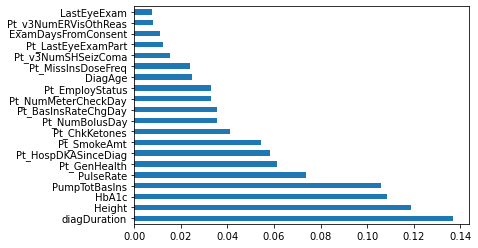

In [48]:

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

Accuracy for the fold no. 1 on the test set: 0.9462086843810759, doublecheck: 0.9462086843810759
Accuracy for the fold no. 2 on the test set: 0.950097213220998, doublecheck: 0.950097213220998
Accuracy for the fold no. 3 on the test set: 0.9487678339818417, doublecheck: 0.9487678339818417
0.516604152712659
Threshold value is: 1.0


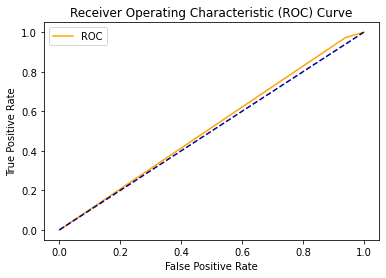

0.8365386333184457
Threshold value is: 1.0


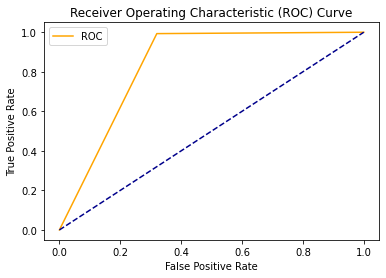


 
 =====================   Train Dataset    ======================
98.29299913569577
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       150
         1.0       0.99      0.99      0.99      4478

    accuracy                           0.98      4628
   macro avg       0.88      0.84      0.86      4628
weighted avg       0.98      0.98      0.98      4628



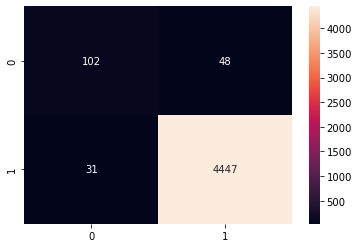

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
94.36163318211277
              precision    recall  f1-score   support

         0.0       0.07      0.06      0.06        50
         1.0       0.97      0.97      0.97      1493

    accuracy                           0.94      1543
   macro avg       0.52      0.52      0.52      1543
weighted avg       0.94      0.94      0.94      1543



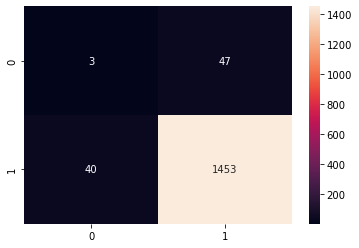

Accuracy of classifier on test set: 0.94


 =======================   Test-ROC    =========================
roc_auc = 0.5166


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.06       0.97320831]
average accuracy:  0.516604152712659


In [49]:
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "uniform", # uniform, distance
    algorithm =  'brute', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)

# knn.fit(X_train, Y_train)
knn = cross_val(knn)

# pred=knn.predict(X_test)
# pred_train=knn.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(knn, X_test, Y_test)
optimal_threshold_train= optimal_thresh(knn, X_train, Y_train)

pred = (knn.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (knn.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(knn, X_train, Y_train, pred_train)
test_results(knn, X_test, Y_test, pred)

# ROC
ROC_results(knn, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(knn, Y_test, pred)

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.9591704471808166, doublecheck: 0.9591704471808166
Accuracy for the fold no. 2 on the test set: 0.9604666234607907, doublecheck: 0.9604666234607907
Accuracy for the fold no. 3 on the test set: 0.9610894941634242, doublecheck: 0.9610894941634242
0.821138647019424
Threshold value is: 0.9783559745913709


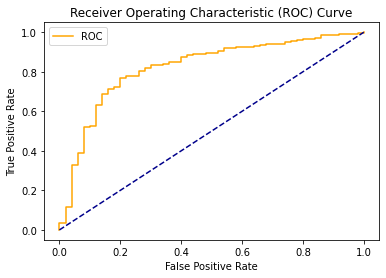

0.8333363108530594
Threshold value is: 0.9854610329170505


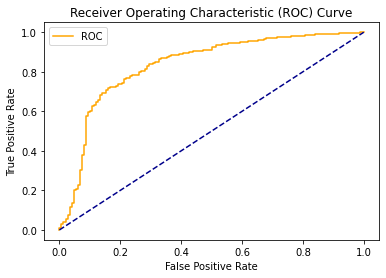


 
 =====================   Train Dataset    ======================
72.2990492653414
              precision    recall  f1-score   support

         0.0       0.09      0.84      0.16       150
         1.0       0.99      0.72      0.83      4478

    accuracy                           0.72      4628
   macro avg       0.54      0.78      0.50      4628
weighted avg       0.96      0.72      0.81      4628



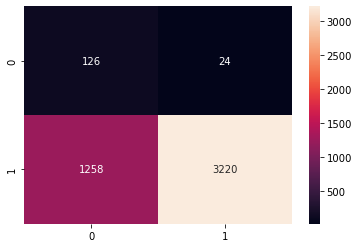

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
76.79844458846404
              precision    recall  f1-score   support

         0.0       0.10      0.80      0.18        50
         1.0       0.99      0.77      0.86      1493

    accuracy                           0.77      1543
   macro avg       0.55      0.78      0.52      1543
weighted avg       0.96      0.77      0.84      1543



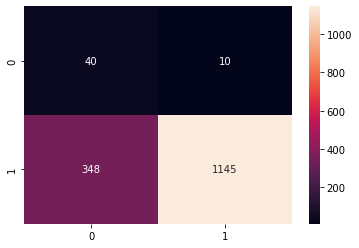

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.8211


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.76691226]
average accuracy:  0.783456128600134


In [50]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(lda, X_test, Y_test)
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


## Model 7- Gaussian Naive Bayes

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 1 on the test set: 0.948801036941024, doublecheck: 0.948801036941024
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 2 on the test set: 0.9410239792611795, doublecheck: 0.9410239792611795
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 3 on the test set: 0.9448767833981842, doublecheck: 0.9448767833981842
GaussianNB(var_smoothing=1.0)
0.800040187541862
Threshold value is: 0.9919805434661711


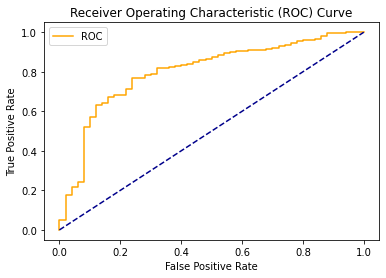

0.8033675748101831
Threshold value is: 0.9948187343292951


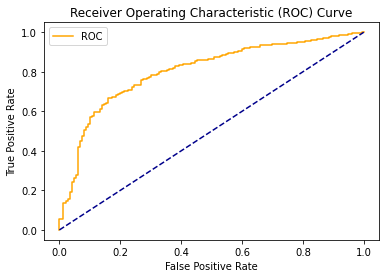


 
 =====================   Train Dataset    ======================
67.17804667242869
              precision    recall  f1-score   support

         0.0       0.08      0.84      0.14       150
         1.0       0.99      0.67      0.80      4478

    accuracy                           0.67      4628
   macro avg       0.53      0.75      0.47      4628
weighted avg       0.96      0.67      0.78      4628



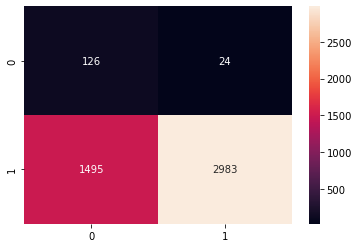

Accuracy of on training set: 0.94


 =====================   Test Dataset    =======================
76.86325340246273
              precision    recall  f1-score   support

         0.0       0.10      0.76      0.18        50
         1.0       0.99      0.77      0.87      1493

    accuracy                           0.77      1543
   macro avg       0.54      0.76      0.52      1543
weighted avg       0.96      0.77      0.84      1543



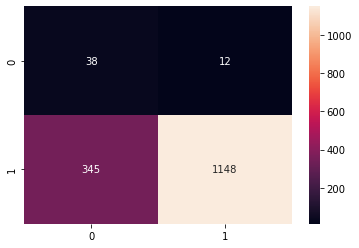

Accuracy of classifier on test set: 0.94


 =======================   Test-ROC    =========================
roc_auc = 0.8


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.76       0.76892163]
average accuracy:  0.7644608171466845


In [51]:
gnb = GaussianNB()

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
# nbModel_grid.fit(X_train, Y_train)
nbModel_grid = cross_val(nbModel_grid)

# best parameters
print(nbModel_grid.best_estimator_)

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)
